## Imports

In [3]:
!pip install wget
!pip install split-folders
!pip install -U keras # upgrade keras to 2.3+ to use tensorflow 2.0+

import os
import wget
import csv
import webbrowser
import numpy as np
import pandas as pd
import split_folders

import matplotlib as mpl
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers
from keras.models import load_model
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

#pip install -U keras # upgrade keras to 2.3+ to use tensorflow 2.0+

%config InlineBackend.figure_format = 'retina' # display sharper image for any plt.show()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=4b5545af96207a64375c0b15f62394c33fde21ae5ae09d6ada6c40b96a547b18
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.


##Data Acquistion

###Scrape images

Download images from a list of URL's for each artists using 'wget' python module.
The text files containing list of URL's for each artists are located at
https://drive.google.com/open?id=1d1h0MnvoZ7NKQpsJvAkd9PvfisSJM75O

In [0]:
artists = ['banksy', 'basquiat', 'blek_le_rat', 'cope', 'daim', 'david_choe', 'dondi_white', 
          'futura2000', 'keith_haring', 'lady_pink', 'os_gemoeos', 'retna', 'roa', 'seen', 
          'taki183', 'vhils']

for i in range(len(artists)):
    base_dir = '/content/drive/My Drive/Graffiti/downloads/' + artists[i]
    os.mkdir(base_dir)
    path = '/content/drive/My Drive/Graffiti/url_links/' + artists[i] + '.txt'
    with open(path) as f:
        reader = csv.reader(f)
        for row in reader:
            try:
                wget.download(row[0], out=base_dir)
            except:
                continue

Rename files in sequential order for each of the artist folders.

In [0]:
for i in range(len(artists)):
    d = '/content/drive/My Drive/graffiti/downloads/' + artists[i]
    counter = 1
    for path in os.listdir(d):
        print("path", path)
        full_path = os.path.join(d, path)
        print("full_path", full_path, '\n')
        if os.path.isfile(full_path):         
            new_path = os.path.join(d, artists[i] + str(counter) + ".jpg")
            print(new_path)
            os.rename(full_path, new_path)
            counter += 1

###Data Cleaning

Manually remove images that are imperfect, ambiguous, duplicates and non-related, 
results in an average number of 200 images for each class. With fairly balanced classes, I will use accuracy as the performance metric.

In [0]:
images_count = []
for i in range(16):
    images_path = '/content/drive/My Drive/graffiti/downloads/' + str(artists[i])
    images_count.append(len(os.listdir(str(images_path))))
    print('{:<15}{}'.format(artists[i], len(os.listdir(str(images_path)))))

banksy         175
basquiat       193
blek_le_rat    202
cope           202
daim           182
david_choe     142
dondi_white    137
futura2000     166
keith_haring   225
lady_pink      176
os_gemoeos     213
retna          246
roa            262
seen           224
taki183        203
vhils          204


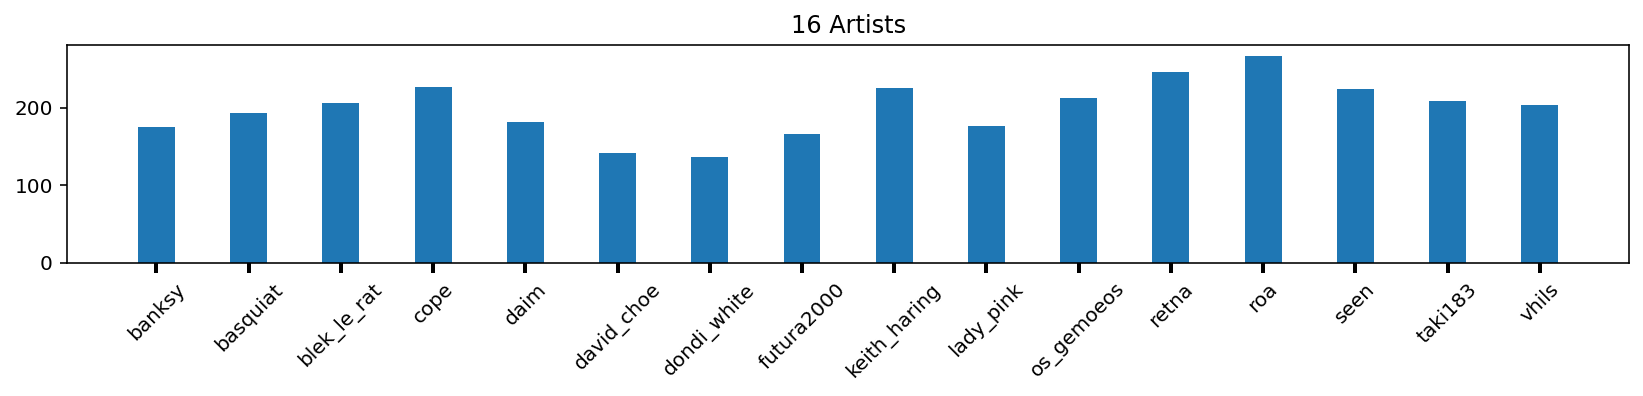

In [0]:
plt.figure(figsize=(14,2))
plt.bar(artists_list, images_count, width = 0.4)
#plt.xlabel('Artists')
#plt.ylabel('Image Counts')
plt.title('16 Artists')
plt.xticks(rotation = 45)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
plt.yticks()
plt.show()


Split imgage files for each artists into a train, validation and test folder. The dataset split ratio percentage is 60, 20, 20.

In [0]:
orig_path = "/content/drive/My Drive/graffiti/downloads/"
output_path = "/content/drive/My Drive/graffiti/artists/"
split_folders.ratio(orig_path, output=output_path, seed=1337, ratio=(.6, .2, .2))

os.rename("My Drive/Graffiti/artists/val", "My Drive/Graffiti/artists/validation")

#Using VGG16 Convolutional Base Network 

Using output of conv_base as inputs to a new model

Instantiate VGG16 model:

In [34]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


### Data Preprocessing and Feature Extraction



- Use ImageDataGenerator from Keras utilities for data preprocessing. Turns image files into batches of pre-processed tensors. Exract images as numpy arrays as well as their labels.
- Run convolutional base over dataset, recording it's output to a numpy array. Extract features from images by calling predict method of the conv_base model.

In [0]:
base_dir = '/content/drive/My Drive/Graffiti/artists/' # images located on Google Drive

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 16))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode= 'categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
        except:
            remaining_samples = features[i * batch_size : (i + 1) * batch_size].shape[0] 
            features[i * batch_size : (i + 1) * batch_size] = features_batch[:remaining_samples]
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch[:remaining_samples]
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1889)
validation_features, validation_labels = extract_features(validation_dir, 628)
test_features, test_labels = extract_features(test_dir, 631)

The extracted features are of shape [samples x 4 x 4 x 512] and have to be flatten to [samples x 8192] before being fed to a densely-connected classifier.

In [0]:
train_features = np.reshape(train_features, (1889, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (628, 4 * 4 * 512))
test_features = np.reshape(test_features, (631, 4 * 4 * 512))

Save flattened extracted features and labels to be for tuning hyperparameters to compare accuracy.

In [0]:
np.save('/content/drive/My Drive/Graffiti/artists/train_features', train_features)
np.save('/content/drive/My Drive/Graffiti/artists/validation_features', validation_features)
np.save('/content/drive/My Drive/Graffiti/artists/test_features', test_features)
np.save('/content/drive/My Drive/Graffiti/artists/train_labels', train_labels)
np.save('/content/drive/My Drive/Graffiti/artists/validation_labels', validation_labels)
np.save('/content/drive/My Drive/Graffiti/artists/test_labels', test_labels)

Load the saved flattened exracted features and labels.

In [0]:
train_features = np.load('/content/drive/My Drive/Graffiti/artists/train_features.npy')
validation_features = np.load('/content/drive/My Drive/Graffiti/artists/validation_features.npy')
test_features = np.load('/content/drive/My Drive/Graffiti/artists/test_features.npy')

train_labels = np.load('/content/drive/My Drive/Graffiti/artists/train_labels.npy')
validation_labels = np.load('/content/drive/My Drive/Graffiti/artists/validation_labels.npy')
test_labels = np.load('/content/drive/My Drive/Graffiti/artists/test_labels.npy')

###Build a base Model

####Dense Units = 256, Dropout = 0.5)

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy', # used to predict classes
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Using TensorFlow backend.


Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 2s 1ms/step - loss: 2.9014 - acc: 0.0815 - val_loss: 2.6051 - val_acc: 0.2150
Epoch 2/30
1889/1889 [==============================] - 2s 1ms/step - loss: 2.5835 - acc: 0.1800 - val_loss: 2.4503 - val_acc: 0.3041
Epoch 3/30
1889/1889 [==============================] - 2s 1ms/step - loss: 2.4109 - acc: 0.2499 - val_loss: 2.3341 - val_acc: 0.3535
Epoch 4/30
1889/1889 [==============================] - 2s 1ms/step - loss: 2.2763 - acc: 0.3134 - val_loss: 2.2288 - val_acc: 0.3885
Epoch 5/30
1889/1889 [==============================] - 2s 1ms/step - loss: 2.1134 - acc: 0.3827 - val_loss: 2.1398 - val_acc: 0.3774
Epoch 6/30
1889/1889 [==============================] - 2s 1ms/step - loss: 2.0243 - acc: 0.4023 - val_loss: 2.0601 - val_acc: 0.4188
Epoch 7/30
1889/1889 [==============================] - 2s 1ms/step - loss: 1.9061 - acc: 0.4373 - val_loss: 1.9990 - val_acc: 0.4347
Epoch 8/30
1889

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 2,101,520
Trainable params: 2,101,520
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/base_model.hdf5")

In [5]:
model_base = load_model("/content/drive/My Drive/Graffiti/artists/base_model.hdf5")
model_base

In [6]:
loss_base, train_accuracy_base = model_base.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_base, validation_accuracy_base = model_base.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (Base model):', train_accuracy_base)
print('Validation accuracy (Base model):', validation_accuracy_base)

628/628 [==============================] - 0s 122us/step
Train accuracy (Base model): 0.8840656280517578
Validation accuracy (Base model): 0.5621019005775452


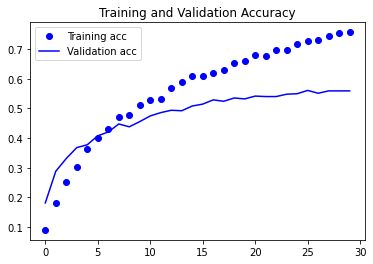

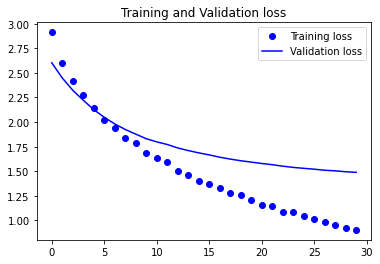

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Highest leveling of Validation accuracy score is desired. It's expected that model will look like it overfits at higher epoch numbers. 
Deep learning neural networks are likely to quickly overfit a training dataset with few examples. Dropout offers an effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.

### Tuning by Adjusting Hyperparameters

#### Dense units = 128

In [0]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 1s 274us/step - loss: 2.9112 - acc: 0.0794 - val_loss: 2.6861 - val_acc: 0.1576
Epoch 2/30
1889/1889 [==============================] - 0s 221us/step - loss: 2.6851 - acc: 0.1297 - val_loss: 2.5852 - val_acc: 0.2182
Epoch 3/30
1889/1889 [==============================] - 0s 230us/step - loss: 2.5603 - acc: 0.1943 - val_loss: 2.5006 - val_acc: 0.2771
Epoch 4/30
1889/1889 [==============================] - 0s 224us/step - loss: 2.4713 - acc: 0.2250 - val_loss: 2.4249 - val_acc: 0.2882
Epoch 5/30
1889/1889 [==============================] - 0s 243us/step - loss: 2.3912 - acc: 0.2652 - val_loss: 2.3553 - val_acc: 0.3360
Epoch 6/30
1889/1889 [==============================] - 0s 223us/step - loss: 2.3039 - acc: 0.2906 - val_loss: 2.2827 - val_acc: 0.3615
Epoch 7/30
1889/1889 [==============================] - 0s 230us/step - loss: 2.2597 - acc: 0.3070 - val_loss: 2.2316 - val_acc: 0.3710
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_128.hdf5")

In [7]:
model_128 = load_model("/content/drive/My Drive/Graffiti/artists/model_128.hdf5")
model_128

In [8]:
loss_128, train_accuracy_128 = model_128.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_128, validation_accuracy_128 = model_128.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (128 Dense Units):', train_accuracy_128)
print('Validation accuracy (128 Dense Units):', validation_accuracy_128)

628/628 [==============================] - 0s 137us/step
Train accuracy (128 Dense Units): 0.7818951606750488
Validation accuracy (128 Dense Units): 0.5398089289665222


####Dense units = 512

In [0]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 1s 345us/step - loss: 2.8945 - acc: 0.0985 - val_loss: 2.5398 - val_acc: 0.2022
Epoch 2/30
1889/1889 [==============================] - 1s 303us/step - loss: 2.5225 - acc: 0.1938 - val_loss: 2.3385 - val_acc: 0.3137
Epoch 3/30
1889/1889 [==============================] - 1s 292us/step - loss: 2.2725 - acc: 0.2917 - val_loss: 2.1803 - val_acc: 0.3662
Epoch 4/30
1889/1889 [==============================] - 1s 295us/step - loss: 2.0803 - acc: 0.3732 - val_loss: 2.0551 - val_acc: 0.4061
Epoch 5/30
1889/1889 [==============================] - 1s 299us/step - loss: 1.9050 - acc: 0.4304 - val_loss: 1.9667 - val_acc: 0.4045
Epoch 6/30
1889/1889 [==============================] - 1s 298us/step - loss: 1.7777 - acc: 0.4674 - val_loss: 1.8853 - val_acc: 0.4650
Epoch 7/30
1889/1889 [==============================] - 1s 293us/step - loss: 1.6794 - acc: 0.5034 - val_loss: 1.8278 - val_acc: 0.4713
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_512.hdf5")

In [9]:
model_512 = load_model("/content/drive/My Drive/Graffiti/artists/model_512.hdf5")
model_512

In [10]:
loss_512, train_accuracy_512 = model_512.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_512, validation_accuracy_512 = model_512.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (512 Dense Units):', train_accuracy_512)
print('Validation accuracy (512 Dense Units):', validation_accuracy_512)

628/628 [==============================] - 0s 125us/step
Train accuracy (512 Dense Units): 0.9412387609481812
Validation accuracy (512 Dense Units): 0.5605095624923706


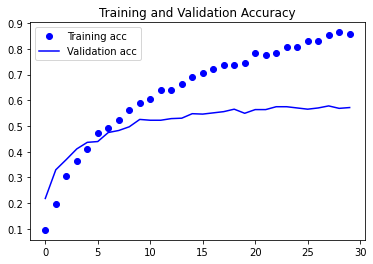

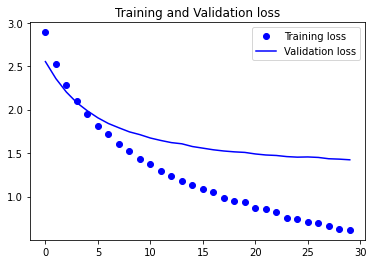

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

####Dropout = 0.25

A regularization technique for neural networks and deep learning models is dropout.
Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 1s 305us/step - loss: 2.7562 - acc: 0.1212 - val_loss: 2.5544 - val_acc: 0.2166
Epoch 2/30
1889/1889 [==============================] - 0s 255us/step - loss: 2.4570 - acc: 0.2372 - val_loss: 2.3683 - val_acc: 0.3217
Epoch 3/30
1889/1889 [==============================] - 0s 261us/step - loss: 2.2346 - acc: 0.3515 - val_loss: 2.2070 - val_acc: 0.3710
Epoch 4/30
1889/1889 [==============================] - 0s 249us/step - loss: 2.0514 - acc: 0.4156 - val_loss: 2.0741 - val_acc: 0.4076
Epoch 5/30
1889/1889 [==============================] - 0s 262us/step - loss: 1.8756 - acc: 0.4701 - val_loss: 1.9772 - val_acc: 0.4315
Epoch 6/30
1889/1889 [==============================] - 0s 261us/step - loss: 1.7590 - acc: 0.4950 - val_loss: 1.8985 - val_acc: 0.4475
Epoch 7/30
1889/1889 [==============================] - 0s 258us/step - loss: 1.6141 - acc: 0.5521 - val_loss: 1.8375 - val_acc: 0.4697
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_dropout_25.hdf5")

In [11]:
model_dropout_25 = load_model("/content/drive/My Drive/Graffiti/artists/model_dropout_25.hdf5")
model_dropout_25

In [12]:
loss_dropout_25, train_accuracy_dropout_25 = model_dropout_25.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_dropout_25, validation_accuracy_dropout_25 = model_dropout_25.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (0.25 Dropout):', train_accuracy_dropout_25)
print('Validation accuracy (0.25 Dropout):', validation_accuracy_dropout_25)

628/628 [==============================] - 0s 129us/step
Train accuracy (0.25 Dropout): 0.9391212463378906
Validation accuracy (0.25 Dropout): 0.5573248267173767


With a lower dropout probability of 0.25 compared to base model of 0.50, this results in more overfitting of training dataset.

####Dropout = 0.65

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.65))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 0s 245us/step - loss: 3.0729 - acc: 0.0720 - val_loss: 2.6510 - val_acc: 0.1640
Epoch 2/30
1889/1889 [==============================] - 0s 216us/step - loss: 2.7277 - acc: 0.1292 - val_loss: 2.5516 - val_acc: 0.2229
Epoch 3/30
1889/1889 [==============================] - 0s 211us/step - loss: 2.5784 - acc: 0.1837 - val_loss: 2.4710 - val_acc: 0.2723
Epoch 4/30
1889/1889 [==============================] - 0s 210us/step - loss: 2.4630 - acc: 0.2356 - val_loss: 2.3882 - val_acc: 0.3153
Epoch 5/30
1889/1889 [==============================] - 0s 217us/step - loss: 2.3882 - acc: 0.2684 - val_loss: 2.3074 - val_acc: 0.3487
Epoch 6/30
1889/1889 [==============================] - 0s 202us/step - loss: 2.2811 - acc: 0.3044 - val_loss: 2.2317 - val_acc: 0.3678
Epoch 7/30
1889/1889 [==============================] - 0s 209us/step - loss: 2.2094 - acc: 0.3208 - val_loss: 2.1593 - val_acc: 0.3838
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_dropout_65.hdf5")

In [13]:
model_dropout_65 = load_model("/content/drive/My Drive/Graffiti/artists/model_dropout_65.hdf5")
model_dropout_65

In [14]:
loss_dropout_65, train_accuracy_dropout_65 = model_dropout_65.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_dropout_65, validation_accuracy_dropout_65 = model_dropout_65.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (0.65 Dropout):', train_accuracy_dropout_65)
print('Validation accuracy (0.65 Dropout):', validation_accuracy_dropout_65)

628/628 [==============================] - 0s 127us/step
Train accuracy (0.65 Dropout): 0.8073054552078247
Validation accuracy (0.65 Dropout): 0.5334395170211792


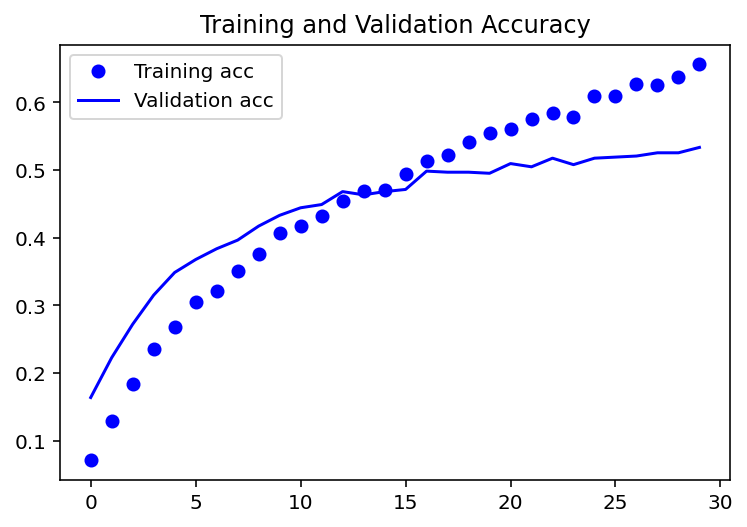

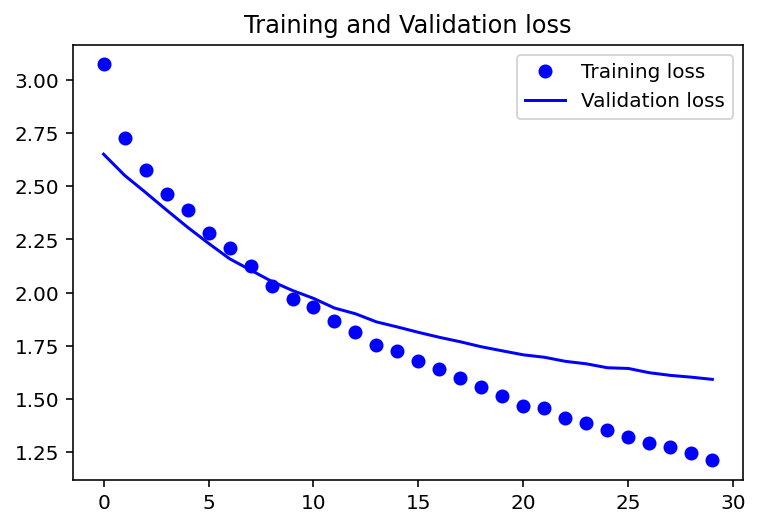

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

#### Optimizer Adam

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 1s 265us/step - loss: 2.9463 - acc: 0.0916 - val_loss: 2.6452 - val_acc: 0.1592
Epoch 2/30
1889/1889 [==============================] - 0s 227us/step - loss: 2.6387 - acc: 0.1673 - val_loss: 2.4913 - val_acc: 0.2596
Epoch 3/30
1889/1889 [==============================] - 0s 226us/step - loss: 2.4183 - acc: 0.2356 - val_loss: 2.3603 - val_acc: 0.3217
Epoch 4/30
1889/1889 [==============================] - 0s 228us/step - loss: 2.2898 - acc: 0.3033 - val_loss: 2.2555 - val_acc: 0.3758
Epoch 5/30
1889/1889 [==============================] - 0s 218us/step - loss: 2.1232 - acc: 0.3764 - val_loss: 2.1524 - val_acc: 0.4076
Epoch 6/30
1889/1889 [==============================] - 0s 217us/step - loss: 1.9902 - acc: 0.4182 - val_loss: 2.0634 - val_acc: 0.4220
Epoch 7/30
1889/1889 [==============================] - 0s 225us/step - loss: 1.8679 - acc: 0.4621 - val_loss: 1.9886 - val_acc: 0.4283
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_adam.hdf5")

In [15]:
model_adam = load_model("/content/drive/My Drive/Graffiti/artists/model_adam.hdf5")
model_adam

In [16]:
loss_adam, train_accuracy_adam = model_adam.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_adam, validation_accuracy_adam = model_adam.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (Adam Optimizer):', train_accuracy_adam)
print('Validation accuracy (Adam Optimizer):', validation_accuracy_adam)

628/628 [==============================] - 0s 136us/step
Train accuracy (Adam Optimizer): 0.9248279333114624
Validation accuracy (Adam Optimizer): 0.5700637102127075


#### Optimizer SGD

Stochastic gradient descent optimizer.

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.SGD(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 0s 247us/step - loss: 2.8002 - acc: 0.0863 - val_loss: 2.6424 - val_acc: 0.1178
Epoch 2/30
1889/1889 [==============================] - 0s 223us/step - loss: 2.5868 - acc: 0.1715 - val_loss: 2.4059 - val_acc: 0.2309
Epoch 3/30
1889/1889 [==============================] - 0s 219us/step - loss: 2.4035 - acc: 0.2292 - val_loss: 2.2985 - val_acc: 0.2723
Epoch 4/30
1889/1889 [==============================] - 0s 217us/step - loss: 2.2623 - acc: 0.2610 - val_loss: 2.2061 - val_acc: 0.2787
Epoch 5/30
1889/1889 [==============================] - 0s 215us/step - loss: 2.1217 - acc: 0.3182 - val_loss: 2.0820 - val_acc: 0.2914
Epoch 6/30
1889/1889 [==============================] - 0s 228us/step - loss: 2.0229 - acc: 0.3483 - val_loss: 1.9497 - val_acc: 0.3854
Epoch 7/30
1889/1889 [==============================] - 0s 209us/step - loss: 1.9312 - acc: 0.3812 - val_loss: 1.8828 - val_acc: 0.4188
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_SGD.hdf5")

In [17]:
from keras.models import load_model
model_SGD = load_model("/content/drive/My Drive/Graffiti/artists/model_SGD.hdf5")
model_SGD

In [18]:
loss_SGD, train_accuracy_SGD = model_SGD.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_SGD, validation_accuracy_SGD = model_SGD.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (SGD Optimizer):', train_accuracy_SGD)
print('Validation accuracy (SGD Optimizer):', validation_accuracy_SGD)

628/628 [==============================] - 0s 122us/step
Train accuracy (SGD Optimizer): 0.8512440323829651
Validation accuracy (SGD Optimizer): 0.5461783409118652


#### Adding a Dense layer

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 1889 samples, validate on 628 samples
Epoch 1/30
1889/1889 [==============================] - 1s 334us/step - loss: 3.0280 - acc: 0.0773 - val_loss: 2.7104 - val_acc: 0.1274
Epoch 2/30
1889/1889 [==============================] - 1s 267us/step - loss: 2.7886 - acc: 0.0921 - val_loss: 2.6539 - val_acc: 0.1943
Epoch 3/30
1889/1889 [==============================] - 1s 275us/step - loss: 2.6999 - acc: 0.1196 - val_loss: 2.6041 - val_acc: 0.2277
Epoch 4/30
1889/1889 [==============================] - 0s 259us/step - loss: 2.6580 - acc: 0.1451 - val_loss: 2.5656 - val_acc: 0.2675
Epoch 5/30
1889/1889 [==============================] - 1s 275us/step - loss: 2.5812 - acc: 0.1657 - val_loss: 2.5153 - val_acc: 0.2866
Epoch 6/30
1889/1889 [==============================] - 0s 263us/step - loss: 2.5436 - acc: 0.1959 - val_loss: 2.4683 - val_acc: 0.3153
Epoch 7/30
1889/1889 [==============================] - 1s 270us/step - loss: 2.4867 - acc: 0.2144 - val_loss: 2.4172 - val_acc: 0.3408
E

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_add_dense_layer.hdf5")

In [19]:
model_add_dense_layer = load_model("/content/drive/My Drive/Graffiti/artists/model_add_dense_layer.hdf5")
model_add_dense_layer

In [20]:
loss_add_dense_layer, train_accuracy_add_dense_layer = model_add_dense_layer.evaluate(train_features, train_labels, batch_size=20, verbose=1)
loss_add_dense_layer, validation_accuracy_add_dense_layer = model_add_dense_layer.evaluate(validation_features, validation_labels, batch_size=20, verbose=1)
print('Train accuracy (Add dense layer):', train_accuracy_add_dense_layer)
print('Validation accuracy (Add dense layer):', validation_accuracy_add_dense_layer)

628/628 [==============================] - 0s 123us/step
Train accuracy (Add dense layer): 0.7003705501556396
Validation accuracy (Add dense layer): 0.4872611463069916


### Model selection

In [21]:
print('Baseline Model: One Dense Layer (256 Dense Units), 0.5 Dropout, RMSProp Optimizer\n')
model_tuning = {'Model Tuning': ['Baseline',
                                 '128 Dense Units',
                                 '512 Dense Units',
                                 '0.25 Dropout',
                                 'Adam Optimizer',
                                 'SGD Optimizer', 
                                 'Adding Dense Layer'],
        'Train Accuracy': [train_accuracy_base, train_accuracy_128,
                           train_accuracy_512, train_accuracy_dropout_25,
                           train_accuracy_adam, train_accuracy_SGD,
                           train_accuracy_add_dense_layer],
        'Validation Accuracy': [validation_accuracy_base, validation_accuracy_128,
                                validation_accuracy_512, validation_accuracy_dropout_25,
                                validation_accuracy_adam, validation_accuracy_SGD,
                                validation_accuracy_add_dense_layer],
        }

df = pd.DataFrame(model_tuning, columns = ['Model Tuning', 'Train Accuracy', 
                                           'Validation Accuracy'])
df_sorted = df.sort_values(by='Validation Accuracy', ascending=False)
df_sorted.index = np.arange(1,len(df_sorted)+1)
df_sorted

Baseline Model: One Dense Layer (256 Dense Units), 0.5 Dropout, RMSProp Optimizer



,Model Tuning,Train Accuracy,Validation Accuracy
1,Adam Optimizer,0.924828,0.570064
2,Baseline,0.884066,0.562102
3,512 Dense Units,0.941239,0.560510
4,0.25 Dropout,0.939121,0.557325
5,SGD Optimizer,0.851244,0.546178
6,128 Dense Units,0.781895,0.539809
7,Adding Dense Layer,0.700371,0.487261


By adjusting the hyperparameters, the model with the best result has one dense layer of 256 dense units, 0.5 dropout and using Adam optimizer.

Further optimization was done by changing the batch size from 20 to 30 which resulted in an accuracy result of 0.554. Using the same batch size but increasing the epoch to 45 resulted in an accuracy of 0.546. For both of these adjustments, the model did not produce a significant improvement from the best accuracy of 0.57. 

###Performance Metrics

#### Top 1 Accuracy

In [22]:
loss_base, test_accuracy_base = model_base.evaluate(test_features, test_labels, batch_size=20, verbose=1)

631/631 [==============================] - 0s 130us/step


In [23]:
print('For a model with one dense layer, 256 dense units, 0.5 dropout, Adam optimizer,')
print('Top 1 Accuracy =', test_accuracy_base)

For a model with one dense layer, 256 dense units, 0.5 dropout, Adam optimizer,
Top 1 Accuracy = 0.5451663732528687


####Confusion Matrix

Number of images per artist used for Test Predictions.

In [0]:
dir_list = os.listdir('/content/drive/My Drive/Graffiti/artists/test')

for i in range(len(dir_list)-1):
    path, dirs, files = next(os.walk("/content/drive/My Drive/Graffiti/artists/test/" + str(dir_list[i])))
    test_artist_list.append(str(dir_list[i]) + ': ' + str(len(files)))
    print('{:<14}{}'.format(dir_list[i], len(files)))

daim          36
banksy        34
dondi_white   27
retna         49
cope          44
os_gemoeos    43
taki183       42
futura2000    33
lady_pink     35
keith_haring  44
david_choe    29
blek_le_rat   41
vhils         40
basquiat      38
roa           51
seen          45


Use the test_labels of images and calling the predict method of the base model on the test features to create a confusion matrix. 

In [0]:
test_labels_argmax = np.argmax(test_labels, axis=1)

out = model_base.predict(test_features)
y_pred = np.argmax(out, axis=1)

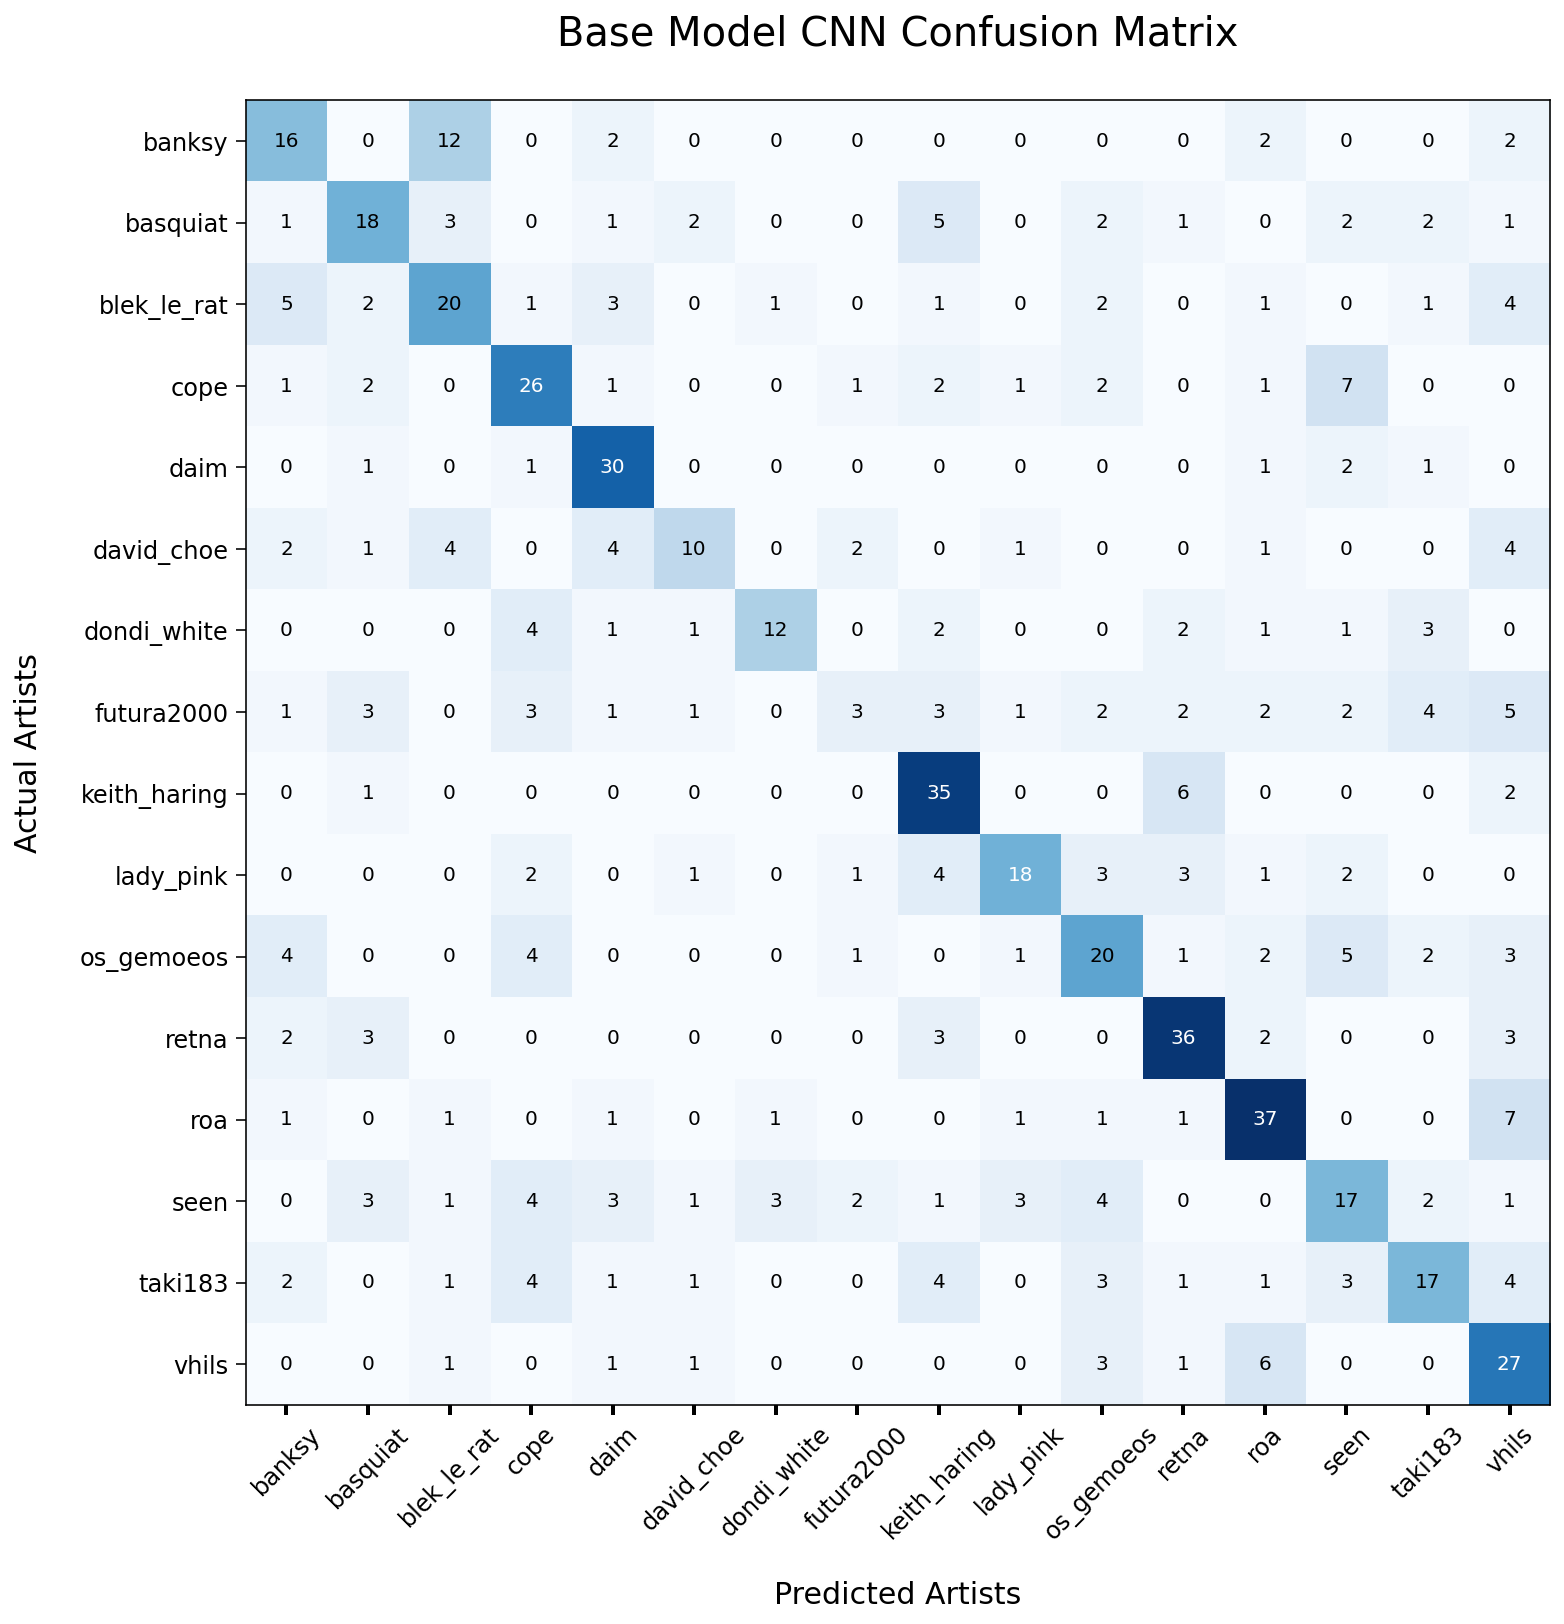

In [0]:
artists_list = ['banksy','basquiat', 'blek_le_rat', 'cope', 'daim', 'david_choe', 'dondi_white', 
               'futura2000', 'keith_haring', 'lady_pink', 'os_gemoeos', 'retna', 'roa', 'seen', 
               'taki183', 'vhils']

cm = confusion_matrix(test_labels_argmax, y_pred, binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm)
fig.set_size_inches(12, 12)
plt.title('Base Model CNN Confusion Matrix', pad = -5, fontsize = 20)
plt.xlabel('Predicted Artists', fontsize = 15, labelpad = 18)
plt.ylabel('Actual Artists', fontsize = 15, labelpad = 18)
plt.xticks(np.arange(0,16,1), artists_list, rotation=45, fontsize = 12, )
plt.tick_params(axis='x', length=5)
plt.yticks(np.arange(0,16,1), artists_list, fontsize = 12)
plt.tick_params(axis='y', length=5)
plt.show()

Insight gained from the confusion matrix shows the model performed great for 4 artists, was confused between two artists and had a hard time with predictions for the artist Futura2000.

Shown in dark blue, the model did great for 4 artists. These 4 artists have one thing in common, their style of art is singular. Daim’s style is mainly 3-D with lots of angle shapes, Roa is mostly of wild animals in minimal color, 
Keith Haring always uses bold outline of figures and Retna mainly does colorful bold hieroglyphs and calligraphy.

The model was mixed up with Banksy and Blek le Rat. Googling and reading more about Blek le Rat and Banksy, the prediction mix up is acceptable since Banksy was inspired by Blek le Rat and thus there’s a lot of visual similarity to their works. 

The model had a hard time classifying the wide range of style of for the artist Futura2000. His style ranged from abstract, to his signature motif of point man and the atom structure, to lettering and tagging.

#### Top 3 Accuracy

Top 3 accuracy score measures how often the model predictions falls in the top 3 values of the softmax distribution. It is a more realistic performance metric than the absolute results from Top 1 accuracy score and the confusion matrix. Top 3 accuracy score is a more suited metric for this project due to the small dataset, large class size and the visual recognition challenge of discerning similar patterns and styles in artworks.

In [0]:
test_labels_argmax = np.argmax(test_labels, axis=1)

out = model_adam.predict_proba(test_features)
y_pred = np.argsort(out, axis=1)[:,-3:]
print('Actual predictions for 5 samples:', test_labels_argmax[:5])
print('Top 3 predictions for 5 samples:\n', y_pred[:5])

Actual predictions for 5 samples: [11  4 13 13 14]
Top 3 predictions for 5 samples:
 [[ 8 14 11]
 [ 0  2  4]
 [10 14  1]
 [ 7 11  2]
 [ 8  1 14]]


In [0]:
counter = 0
for i in range(len(test_labels_argmax)): 
    if test_labels_argmax[i] in y_pred[i]:
        counter +=1
    else:
        continue
    
print('Top-3-Accuracy:', counter/(len(test_labels_argmax)))

Top-3-Accuracy: 0.768621236133122


For a small dataset and large class size, the model did a good job of predicting correctly within the top 3 values for each class 77% of the time. 

#Data Augmentation

Extending the conv_base by adding Dense layers on top, and running the whole thing end-to-end on the input data. This creates synthetically larger sample sizes. 

Leverage data augmentation by artificially introduce noise to images, make model more robust to overfitting (regularization) with small image datasets.

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(16, activation='softmax'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 16,816,208
Trainable params: 16,816,208
Non-trainable params: 0
_________________________________________________________________


Freeze the convolutional base network by setting its trainable attribute to False. This prevents the learned weights of the conv_base from being modified. 

In [0]:
conv_base.trainable = False

Not including the frozen conv_base layer, there are four weight tensors (two main weights from dense layers and each of it's bias vectors) that will be trained. 

In [43]:
base_dir = '/content/drive/My Drive/Graffiti/artists/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,          
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,         
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator, 
      steps_per_epoch=100, 
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50, 
      verbose=2)

Found 1889 images belonging to 16 classes.
Found 628 images belonging to 16 classes.
Epoch 1/30
 - 1477s - loss: 2.7010 - acc: 0.1443 - val_loss: 2.4166 - val_acc: 0.2095
Epoch 2/30
 - 57s - loss: 2.4179 - acc: 0.2790 - val_loss: 2.3594 - val_acc: 0.3227
Epoch 3/30
 - 58s - loss: 2.2264 - acc: 0.3620 - val_loss: 2.1352 - val_acc: 0.3482
Epoch 4/30
 - 57s - loss: 2.0595 - acc: 0.4093 - val_loss: 1.9324 - val_acc: 0.4057
Epoch 5/30
 - 59s - loss: 1.9392 - acc: 0.4429 - val_loss: 1.6718 - val_acc: 0.4555
Epoch 6/30
 - 61s - loss: 1.8339 - acc: 0.4788 - val_loss: 1.8900 - val_acc: 0.4242
Epoch 7/30
 - 58s - loss: 1.7555 - acc: 0.4980 - val_loss: 2.0608 - val_acc: 0.4676
Epoch 8/30
 - 63s - loss: 1.6554 - acc: 0.5288 - val_loss: 1.9249 - val_acc: 0.4846
Epoch 9/30
 - 58s - loss: 1.6382 - acc: 0.5315 - val_loss: 1.6654 - val_acc: 0.4795
Epoch 10/30
 - 61s - loss: 1.5253 - acc: 0.5686 - val_loss: 2.1978 - val_acc: 0.5030
Epoch 11/30
 - 58s - loss: 1.5092 - acc: 0.5607 - val_loss: 1.5476 - val

In [0]:
model.save("/content/drive/My Drive/Graffiti/artists/model_image_aug_4_30.hdf5")

In [45]:
model_augment = load_model("/content/drive/My Drive/Graffiti/artists/model_image_aug_4_30.hdf5")
model_augment

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [46]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical',
        shuffle = True)

train_loss, train_acc = model_augment.evaluate_generator(train_generator, steps=50)
validation_loss, validation_acc = model_augment.evaluate_generator(validation_generator, steps=50)
test_loss, test_acc = model_augment.evaluate_generator(test_generator, steps=50)
print('train acc:', train_acc)
print('validation acc:', validation_acc)
print('test acc:', test_acc)

Found 631 images belonging to 16 classes.
train acc: 0.734000027179718
validation acc: 0.591093122959137
test acc: 0.5395284295082092


Loss and Accuracy Curves during training

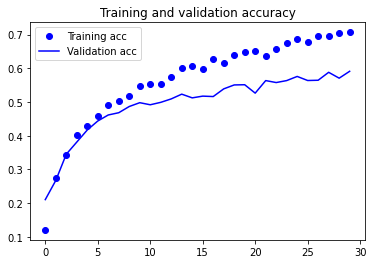

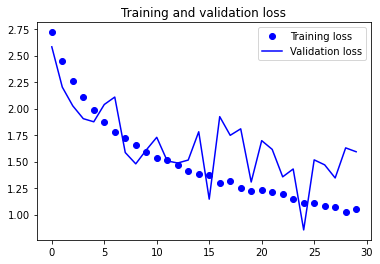

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The test accuracy with data augmentation is 0.54. Although data augmentation helped reduce overfitting training and validation accuracy, using unseen test samples, it did not do better than the base model of 0.54 (with RMSProp or Adam optimizer).

#New sample classification

Use the selected model with adam optimizer to classify a new sample from the artist 'Daim'

In [35]:
base_dir = '/content/drive/My Drive/Graffiti/artists/'

sample_dir = os.path.join(base_dir, 'sample')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 1))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode= 'categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
        except:
            remaining_samples = features[i * batch_size : (i + 1) * batch_size].shape[0] 
            features[i * batch_size : (i + 1) * batch_size] = features_batch[:remaining_samples]
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch[:remaining_samples]
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

sample_features, sample_labels = extract_features(sample_dir, 1)
sample_features = np.reshape(sample_features, (1, 4 * 4 * 512))

Found 1 images belonging to 1 classes.


In [0]:
artists_list = ['Banksy','Jean-Michel_Basquiat', 'Blek_le_Rat', 'Cope2', 'DAIM', 'David_choe', 'dondi_white', 
               'Futura_(graffiti_artist)', 'Keith_Haring', 'Lady_Pink', 'OSGEMEOS', 'Retna', 'ROA_(artist)', 'Seen_(artist)', 
               'TAKI_183', 'Vhils']
out = model_base.predict(sample_features)
y_pred = np.argmax(out, axis=1)

Model predicts the correct artist:

In [38]:
artist_pred = [artists_list[int(y_pred)]]
print("The artist predicted from a new sample artwork is:", artist_pred)

The artist predicted from a new sample artwork is: ['DAIM']


In [0]:
url = 'https://en.wikipedia.org/wiki/' + str(artist_pred[0])
webbrowser.open(url)